In [2]:
import sys
sys.path.append("../data/modules/")

In [3]:
import databasefunctions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
conn = databasefunctions.create_connection("../data/herogames.db")

In [5]:
xp_columns = ["minion_xp", "hero_xp", "structure_xp", "creep_xp", "tricle_xp"]

In [6]:
xp_winner = pd.read_sql_query("""SELECT experience.*, matches.map, matches.mode 
                              FROM experience, matches 
                              WHERE experience.match_id = matches.id AND experience.team = matches.winner""", conn)
xp_winner["game_time"] = np.array(map(round, xp_winner["game_time"]/60))

xp_loser = pd.read_sql_query("""SELECT experience.*, matches.map, matches.mode 
                              FROM experience, matches 
                              WHERE experience.match_id = matches.id AND experience.team != matches.winner""", conn)
xp_loser["game_time"] = np.array(map(round, xp_loser["game_time"]/60))

xp_winner["sum"] = xp_winner[xp_columns].apply(np.sum, axis = 1)
xp_loser["sum"] = xp_loser[xp_columns].apply(np.sum, axis = 1)

xp_on_level = [0, 2010, 4164, 6318, 8472, 10626, 13929, 17232, 20535, 23838, 27141, 31593, 36045, 40497, 
                 44949, 49401, 55001, 60601, 66201, 71801, 80801, 90801, 102301, 115301, 130301, 147301, 166801, 188801, 213801, 241801,]
xp_winner["level"] = np.digitize(xp_winner["sum"], xp_on_level)
xp_loser["level"] = np.digitize(xp_loser["sum"], xp_on_level)

In [74]:
xp_winner["game_length"] = xp_winner.groupby("match_id")["game_time"].transform(max)
xp_loser["game_length"] = xp_loser.groupby("match_id")["game_time"].transform(max)

In [75]:
xp_winner.head()

,id,match_id,game_time,team,minion_xp,hero_xp,structure_xp,creep_xp,tricle_xp,map,mode,sum,level,game_length
0,2,1,1.0,2,764.0,0.000000,0.0,0.0,500.0,Alterac Pass,Quick Match,1264.000000,1,13.0
1,4,1,2.0,2,3519.0,415.039062,0.0,0.0,1700.0,Alterac Pass,Quick Match,5634.039062,3,13.0
2,6,1,3.0,2,6188.0,873.278809,0.0,0.0,2900.0,Alterac Pass,Quick Match,9961.278809,5,13.0
3,8,1,4.0,2,7000.0,2947.082520,0.0,224.0,4100.0,Alterac Pass,Quick Match,14271.082520,7,13.0
4,10,1,5.0,2,8944.0,3917.504883,500.0,224.0,5300.0,Alterac Pass,Quick Match,18885.504883,8,13.0


18.763292634895627

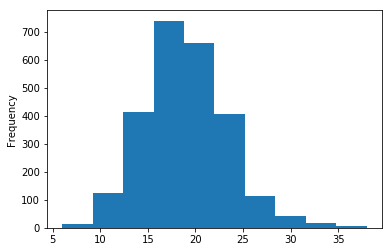

In [200]:
xp_winner.groupby("match_id")["game_length"].max().plot(kind = "hist")
xp_winner.groupby("match_id")["game_length"].max().mean()

In [76]:
df = pd.DataFrame(xp_winner["level"].subtract(xp_loser["level"]))
df["game_time"] = xp_winner["game_time"]
df["game_length"] = xp_winner["game_length"]

In [218]:
def plot_level_difference(game_length_limits):
    colormap = plt.cm.viridis 
    colors = [colormap(i) for i in np.linspace(0, 1,7)]

    games = df[(df["game_length"] >= game_length_limits[0]) & (df["game_length"] <= game_length_limits[1])][["game_time","level"]]
    n = games[games["game_time"] == 1]["game_time"].count()
    piv = games.pivot_table(index = "game_time", columns = "level", aggfunc = len)
    piv.fillna(0, inplace = True)
    #piv_norm = piv
    piv_norm = piv.div(piv.sum(axis = 1), axis =0)
    #piv_norm = piv.div(piv.loc[1.0].sum())
    
    fig, ax = plt.subplots()
    
    keys = piv_norm.keys()
    
    p = 0
    for k in keys[keys <= -3]:
        p = p + piv_norm[k]
    ax.plot(p, "x-", label = "<= -3", color = colors[6])
    
    for i in keys[(keys >= -2) & (keys <= 2)]:
        ax.plot(piv_norm[i], "x-", label = i, color = colors[(-i + 3)])

    p = 0
    for k in keys[keys >= 3]:
        p = p + piv_norm[k]
    ax.plot(p, "x-", label = ">= 3", color = colors[0])

    ax.axvspan(game_length_limits[0], game_length_limits[1], facecolor = 'C7')
    ax.legend(title = "Level diff")
    ax.set(xlim = [0,min(game_length_limits[1], 30)],
           xlabel = "game time", 
           ylabel = "Number of games", 
           title = "Number of games {}, game length: {} <= t <= {}".format(n, game_length_limits[0], game_length_limits[1]))
    
    #ax2 = ax.twinx()
    #ax2.set(ylim = [0,1],
    #        ylabel = "Percentage")
    
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1be19668>)

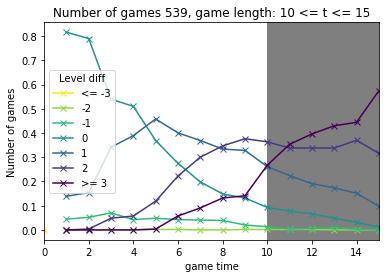

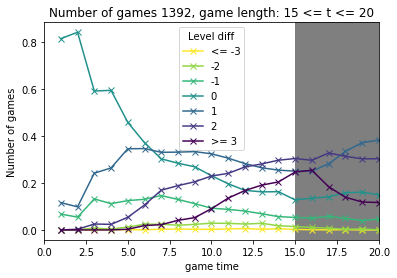

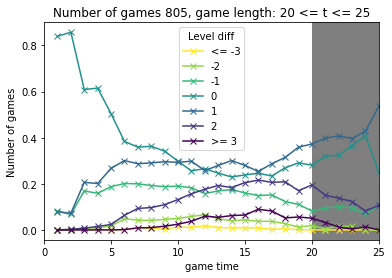

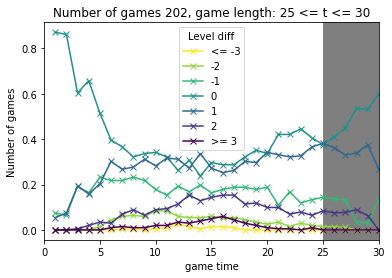

In [219]:
plot_level_difference([10,15])
plot_level_difference([15,20])
plot_level_difference([20,25])
plot_level_difference([25,30])

* Get rid of the effect of games ending

In [220]:
max_game_time_per_map = xp_winner.groupby(["map","match_id"])[["game_time"]].max().reset_index().groupby("map").max()
min_game_time_per_map = xp_winner.groupby(["map","match_id"])[["game_time"]].max().reset_index().groupby("map").min()
median_game_time_per_map = xp_winner.groupby(["map","match_id"])[["game_time"]].max().reset_index().groupby("map").median()

In [221]:
def plot_mean_confidence(df, filters, column, ax, color, limits):
    df_chosen = df[filters].groupby("game_time")[column].mean()
    x = [0] + list(df_chosen.iloc[limits[0]:limits[1]].index)
    df_max = [0] + list(df[filters].groupby("game_time")[column].agg(lambda x: np.mean(x) + np.std(x)))
    df_min = [0] + list(df[filters].groupby("game_time")[column].agg(lambda x: np.mean(x) - np.std(x)))
    
    ax.axhline(0, color = 'k', linewidth = plt.rcParams['axes.linewidth'])
    ax.plot(x, df_chosen[limits[0]:limits[1]+1], c = color)
    ax.plot(x, df_max[limits[0]:limits[1]+1], c = color, linestyle = '--', alpha = 0.5)
    ax.plot(x, df_min[limits[0]:limits[1]+1], c = color, linestyle = '--', alpha = 0.5)
    ax.fill_between(x, df_min[limits[0]:limits[1]+1], df_max[limits[0]:limits[1]+1], 
                    color=color, alpha = 0.1, linestyle = '--')
    
    ax.set_xlim([limits[0],limits[1]])

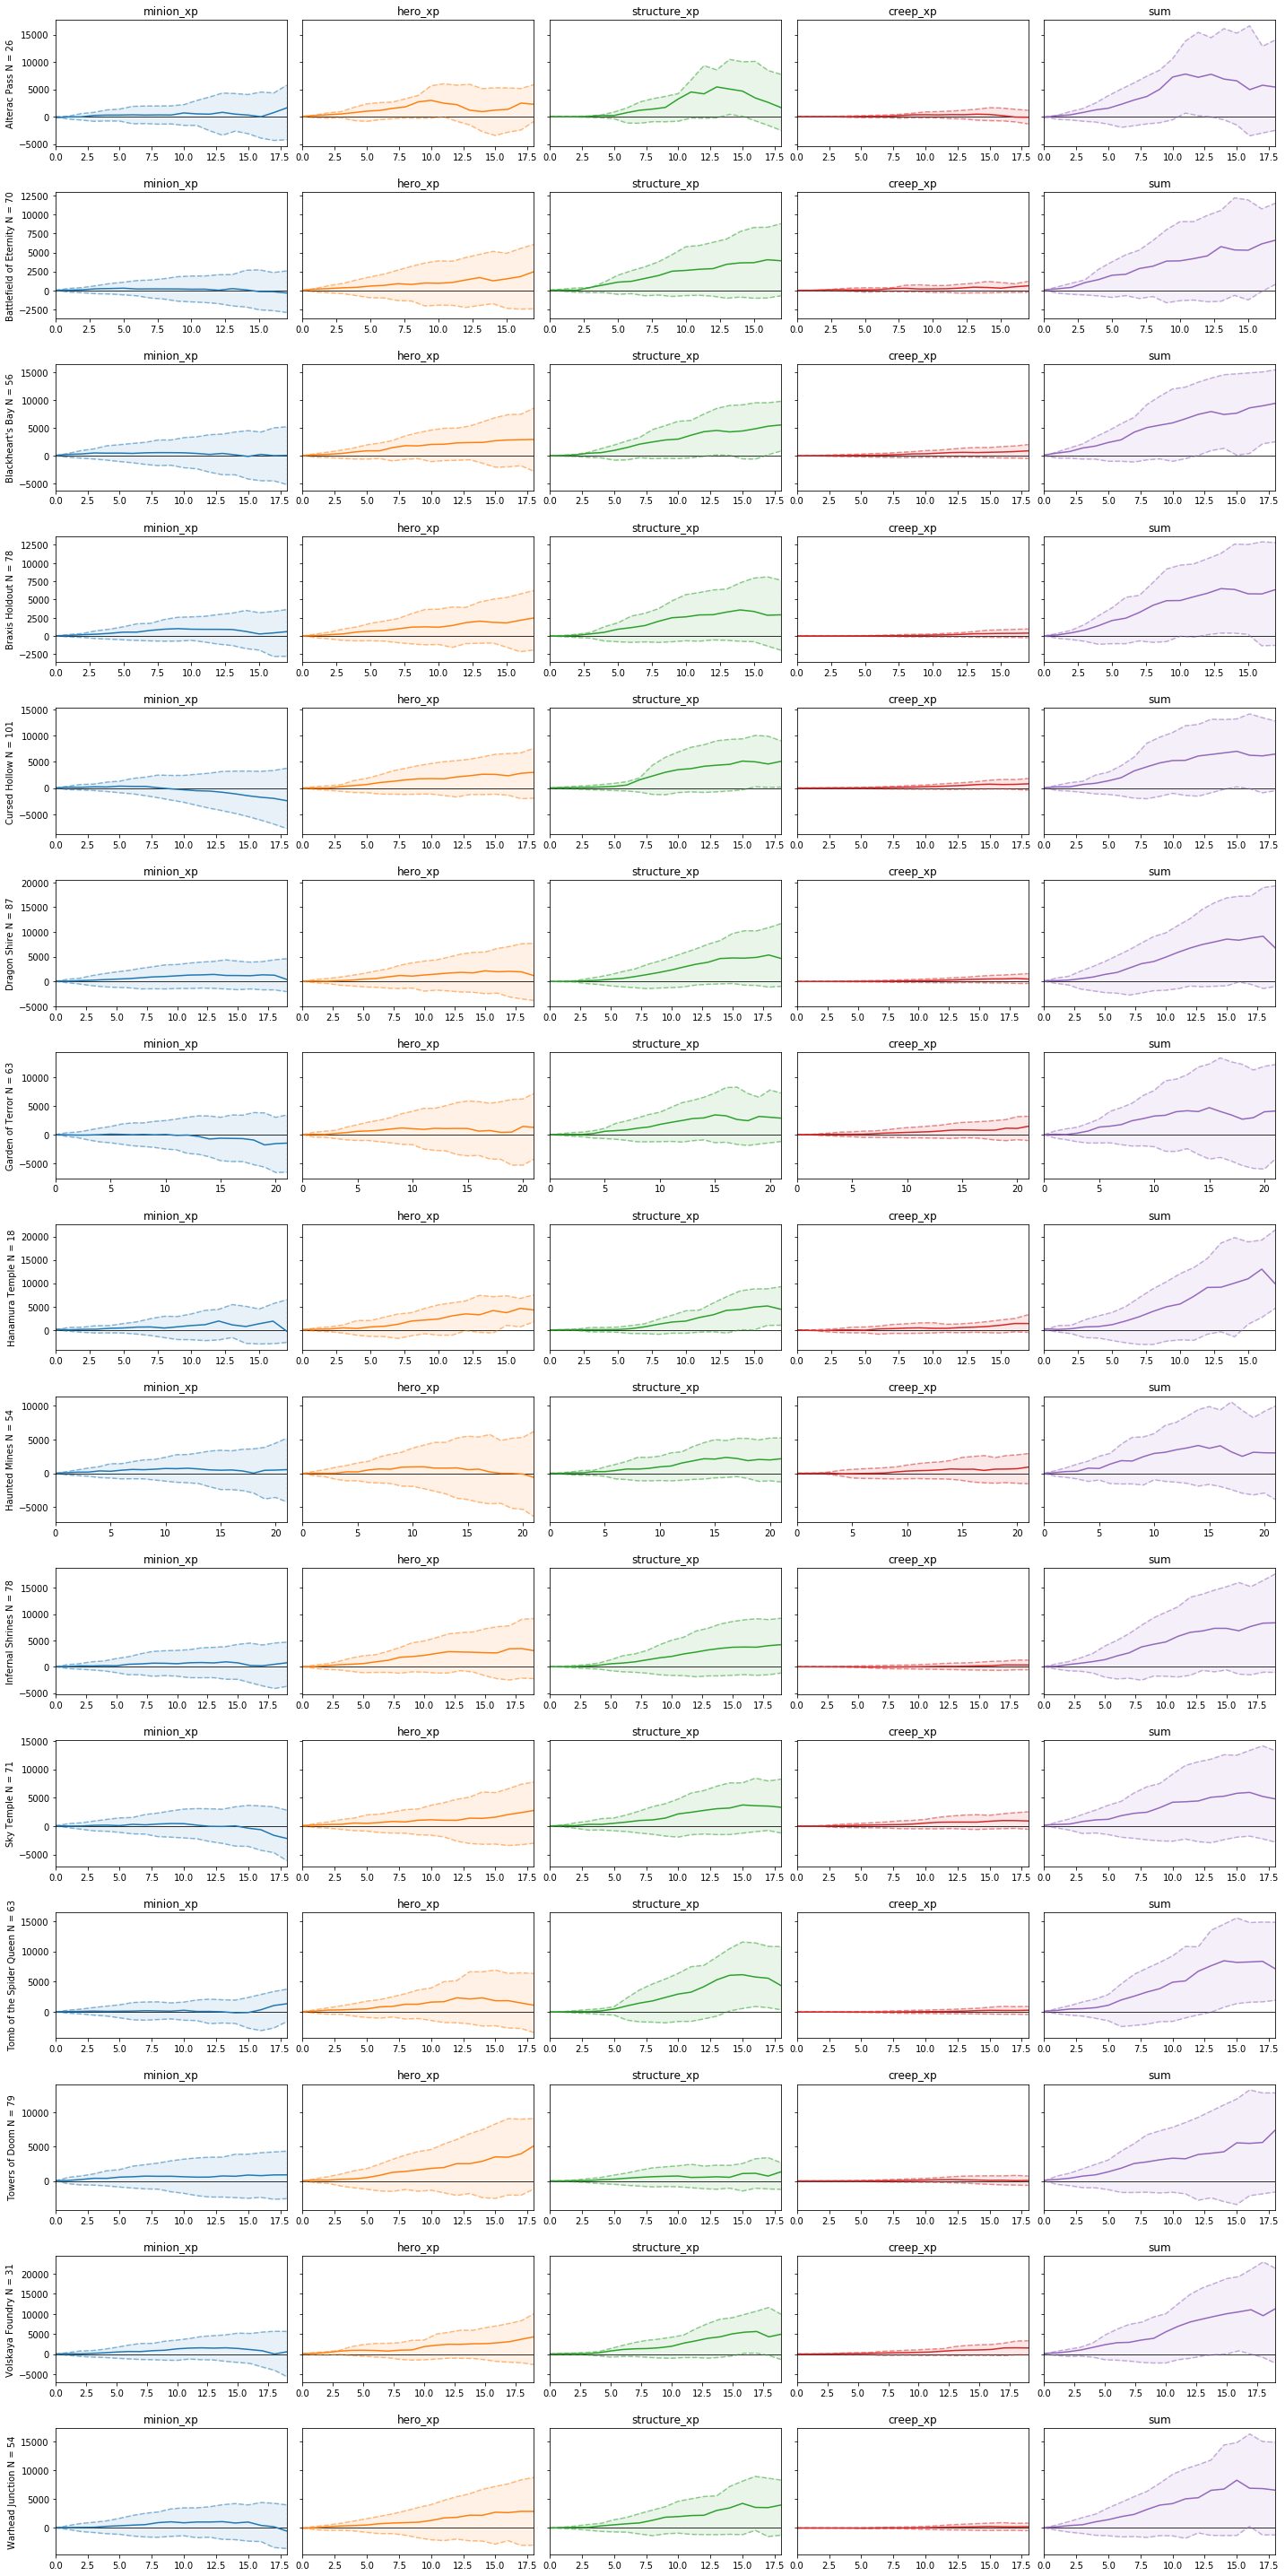

In [226]:
fig, ax = plt.subplots(15,5, figsize = (20,40), sharey = 'row')
#ax_array = ax.flatten()
ax_array = ax

mode = "Quick Match"
columns = ["minion_xp", "hero_xp", "structure_xp", "creep_xp", "sum"]
maps = ['Alterac Pass', 'Battlefield of Eternity', "Blackheart's Bay", 'Braxis Holdout', 'Cursed Hollow',
        'Dragon Shire', 'Garden of Terror', 'Hanamura Temple', 'Haunted Mines', 'Infernal Shrines', 
        'Sky Temple', 'Tomb of the Spider Queen', 'Towers of Doom', 'Volskaya Foundry', 'Warhead Junction']

for i, map_name in enumerate(maps):
    df = xp_winner[columns].subtract(xp_loser[columns])
    df["game_time"] = xp_winner["game_time"]
    num = xp_winner[(xp_winner["map"] == map_name) & (xp_winner["mode"] == mode)].groupby("game_time")["id"].count().iloc[0]
    maxtime = int(median_game_time_per_map.loc[map_name].game_time)
    
    for j, column in enumerate(columns):
        plot_mean_confidence(df, (xp_winner["map"] == map_name) & (xp_winner["mode"] == mode), column, ax_array[i, j], "C" + str(j), [0,maxtime])
        
        ax_array[i, j].set(title = column)
        if j == 0:
            ax_array[i,j].set_ylabel(map_name + " N = " + str(num))
    #if i != 0:
    #    ax_array[i].get_legend().remove()
            #ax_array[i,j].set(xlim =[0,10])
fig.tight_layout()